# Code to generate the synthetic data for Coupled PHUs with negative Binomial noise

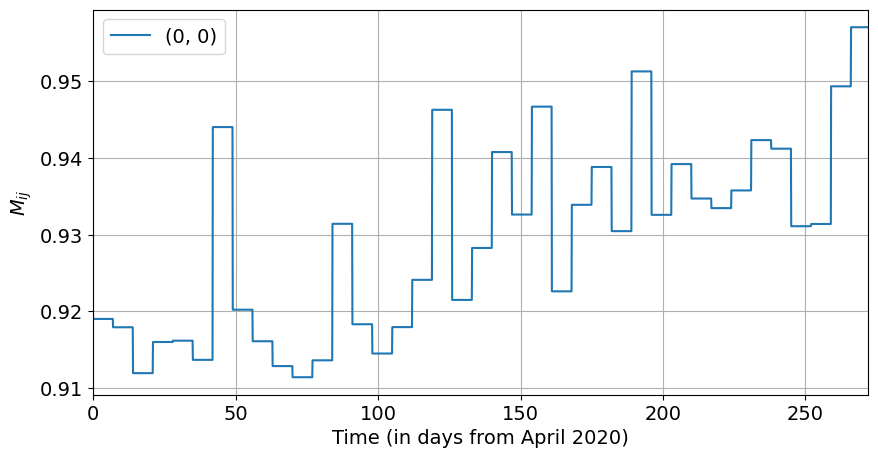

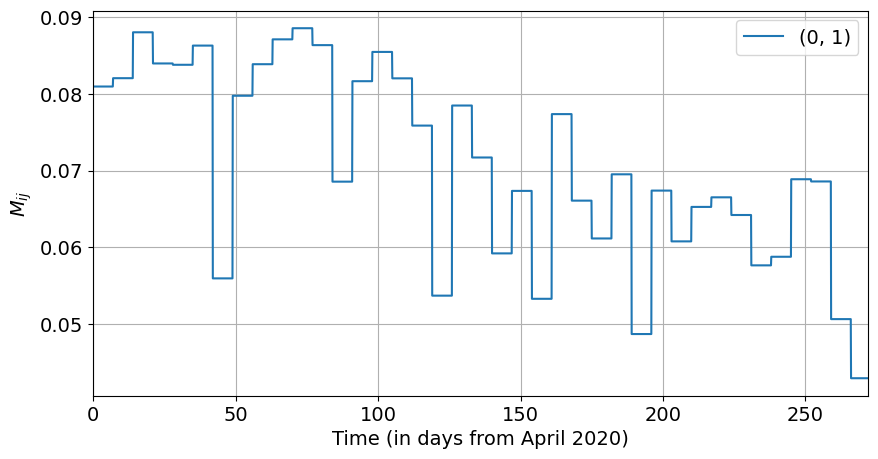

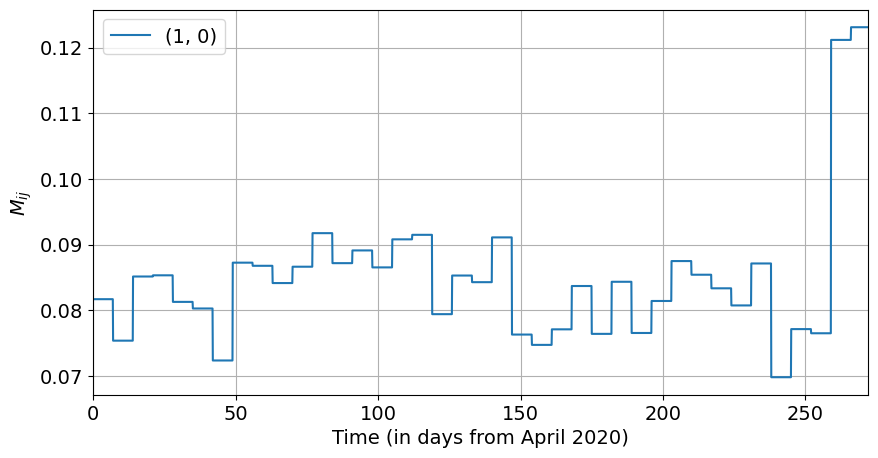

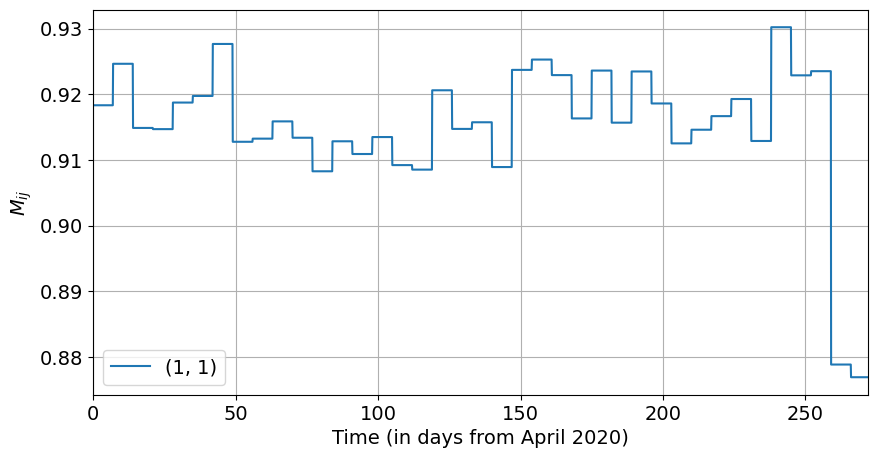

initial infected in PHU1 430.0
total population in PHU1 2794356.0
initial infected in PHU2  94.0
total population in PHU2  696992.0


In [1]:

import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

##### CHANGE HERE #############
### Use the time up to which you need to generate synthetic data for
dt = 0.1
tstart = 0
tlim = 272
t = np.arange(tstart, tlim, 1)

tmoh = np.arange(tstart, tlim, dt)

ndiv = 1/dt


##### CHANGE HERE #############

###### If you have your own data, load it here #######
### Currently loaded infection data from MOH, for April 2020 to March 2021

PHU_path = './../../../PHU_Data/'
Mobility_path = './../../../mobility_tensor/'

Data = np.zeros([365,4])

files = os.listdir(PHU_path)

target_file1 = f'{PHU_path}/30-Toronto.csv'
target_file2 = f'{PHU_path}/34-York.csv'
target_file3 = f'{PHU_path}/04-Durham.csv'
target_file4 = f'{PHU_path}/22-PeelRegion.csv'

Data[:,0] = np.genfromtxt(target_file1, delimiter=',')
Data[:,1] = np.genfromtxt(target_file2, delimiter=',')
Data[:,2] = np.genfromtxt(target_file3, delimiter=',')
Data[:,3] = np.genfromtxt(target_file4, delimiter=',')


population_by_phu = np.genfromtxt(f'{PHU_path}/population_by_phu.csv', delimiter=',')


N_city = 2
# Preallocate compartments
S = np.zeros((len(tmoh),N_city))
E = np.zeros((len(tmoh),N_city))
I = np.zeros((len(tmoh),N_city))
R = np.zeros((len(tmoh),N_city))
D = np.zeros((len(tmoh),N_city))
N = np.zeros((len(tmoh),N_city))

I_synthetic = np.zeros((len(t),N_city))

# Stratification Tensor M
M = np.zeros((4,N_city,N_city,len(tmoh)))


#####################################################################################


#  Below part of code uses the weekly data to generate the daily values 
# of mobility tensor and further saves it in each time step. 

## This part can also be simplified by accessing the required mobility inside the ode solving loop

# Load the Mobility tensor values based on the Flow matrix

# Week number 13 (starting from 0) is April 6th.
# Week number 37 is Sep 21st.

Mtensor = np.zeros([52,2,2])

directory_path = f'{Mobility_path}/stochastic_Tor_Durham'
filesmobility = os.listdir(directory_path)

for ii in range(52):
    
      target_name_part = "Stochastic_matrix"+str(ii)+".dat"
    
      for file in filesmobility:
            if target_name_part == file:
              target_file = file
              break
      else:
        raise FileNotFoundError(f"Could not find any file containing '{target_name_part}'.")

      Mtensor[ii,:,:] = np.genfromtxt(f'{directory_path}/{target_file}', delimiter=' ')



mrange = int((tlim-tstart)/7) + 1


for w in range(mrange): # 39
   
    sw = 7*w
    
    if(w != mrange-1):
        tsw = np.linspace(sw, sw+6, int((1/dt)*6+1))
    else:
        tsw = np.linspace(sw, sw+5, int((1/dt)*5+1))

    
    for swk in range(len(tsw)):
        mindex = int((1/dt) * sw + swk)
        M[0,:,:,mindex] = Mtensor[13+w,0:N_city,0:N_city]
        M[1,:,:,mindex] = Mtensor[13+w,0:N_city,0:N_city]
        M[2,:,:,mindex] = Mtensor[13+w,0:N_city,0:N_city]
        M[3,:,:,mindex] = Mtensor[13+w,0:N_city,0:N_city]
        

    tsw2 = np.linspace(sw+6+dt, sw+7, int((1/dt)*1))
    for swk2 in range(1,len(tsw2)):
        mindex2 = mindex + swk2
        M[0,:,:,mindex2] = Mtensor[13+w,0:N_city,0:N_city]
        M[1,:,:,mindex2] = Mtensor[13+w,0:N_city,0:N_city]
        M[2,:,:,mindex2] = Mtensor[13+w,0:N_city,0:N_city]
        M[3,:,:,mindex2] = Mtensor[13+w,0:N_city,0:N_city]




### Plot mobilities
mpl.rcParams.update({'font.size':14})
for i in range(N_city):
    for j in range(N_city):
        plt.figure(i+j,figsize=(10,5))
        plt.plot(tmoh, M[0,i,j,:], label=f'{i,j}')
        plt.legend(loc='best')
        plt.xlabel('Time (in days from April 2020)')
        plt.xlim([0,tlim])
        plt.ylabel('$M_{ij}$')
        plt.grid()
        plt.show()


#####Force of infection , Lambda
L_Force = np.zeros((len(tmoh),N_city))


###### CHANGE HERE ###########
total = np.zeros((N_city))

total[0] = population_by_phu[29,1]

total[1] = population_by_phu[3,1]

 
###### CHANGE HERE ###########

E[0,0] = Data[0,0]
I[0,0] = Data[0,0]
R[0,0] = 0
D[0,0] = 0
N[0,0] = total[0]
S[0,0] = N[0,0] - E[0,0] - I[0,0] - R[0,0] - D[0,0]


E[0,1] = Data[0,2]
I[0,1] = Data[0,2]
R[0,1] = 0
D[0,1] = 0
N[0,1] = total[1]
S[0,1] = N[0,1] - E[0,1] - I[0,1] - R[0,1] - D[0,1]


I_synthetic[0,0] = I[0,0]
I_synthetic[0,1] = I[0,1]


# Model parameters - Taken from Southern Ontario - COVID MBE paper
gamma_e = 1/15
gamma_i = 1/5
gamma_r = 1/11
gamma_d = 1/750

beta_e = np.zeros((len(tmoh),N_city)) 
beta_i = np.zeros((len(tmoh),N_city))

beta_calibrated = np.zeros((len(tmoh),N_city))


print("initial infected in PHU1",I[0,0])

print("total population in PHU1",total[0])

print("initial infected in PHU2 ",I[0,1])

print("total population in PHU2 ",total[1])


#### PEEL - 234 , 1451022

#### Toronto - 430 , 2794356

### York - 212, 1173334

### Durham - 94   - 696992



# Manually Calibrated Beta values for each PHU

In [2]:

###############################################

# original    
a0 =   0.15
a1 =  -0.1
t1 =  20
a2 =   0.05
t2 =  35
a3 =   -0.07
t3 = 60
a4 =  0.035
t4 = 80
a5 =  0.08
t5 = 140
a6 =  -0.065
t6 = 180
a7 =  0.025
t7 = 190
a8 =  -0.015
t8 = 230  

beta_i[:,0] = a0  + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh))) + a3/(1 + np.exp((t3-tmoh))) + a4/(1 + np.exp((t4-tmoh))) + a5/(1 + np.exp((t5-tmoh)))  + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) + a8/(1 + np.exp((t8-tmoh)))
beta_e[:,0] = beta_i[:,0]

################### Durham ##########################################################

# Original

a0 =   0.14
a1 =  -0.115
t1 =  20
a2 =   0.06
t2 =  35
a3 =   -0.05
t3 = 65
a4 =  0.035
t4 = 90
a5 =  0.06
t5 = 140
a6 =  -0.075
t6 = 180
a7 =  0.06
t7 = 190
a8 =  -0.025
t8 = 250


beta_i[:,1] = a0  + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh))) + a3/(1 + np.exp((t3-tmoh))) + a4/(1 + np.exp((t4-tmoh))) + a5/(1 + np.exp((t5-tmoh)))  + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) + a8/(1 + np.exp((t8-tmoh)))
beta_e[:,1] = beta_i[:,1]



################### York ##########################################################

# Original
# a0 =   0.12
# a1 =  -0.1
# t1 =  20
# a2 =   0.08
# t2 =  35
# a3 =   -0.04
# t3 = 50
# a4 =  0.07
# t4 = 130
# a5 = -0.04
# t5 = 200
# a6 = 0.0
# t6 = 250




# beta_i[:,2] = a0  + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh))) + a3/(1 + np.exp((t3-tmoh))) + a4/(1 + np.exp((t4-tmoh))) + a5/(1 + np.exp((t5-tmoh)))  + a6/(1 + np.exp((t6-tmoh)))
# beta_e[:,2] = beta_i[:,2]



################### Peel ##########################################################

# original
# a0 =   0.15
# a1 =  -0.1
# t1 =  20
# a2 =   0.05
# t2 =  35
# a3 =   -0.07
# t3 = 60
# a4 =  0.035
# t4 = 80
# a5 =  0.08
# t5 = 140
# a6 =  -0.09
# t6 = 180
# a7 =  0.065
# t7 = 190
# a8 =  -0.035
# t8 = 235


# beta_i[:,3] = a0  + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh))) + a3/(1 + np.exp((t3-tmoh))) + a4/(1 + np.exp((t4-tmoh))) + a5/(1 + np.exp((t5-tmoh)))  + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) + a8/(1 + np.exp((t8-tmoh)))
# beta_e[:,3] = beta_i[:,3]


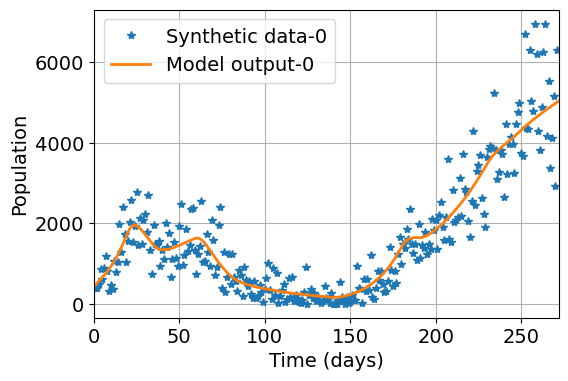

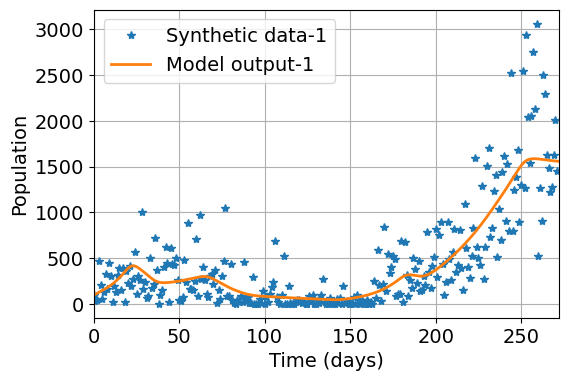

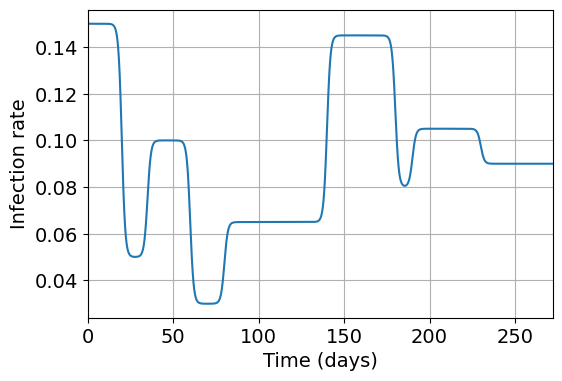

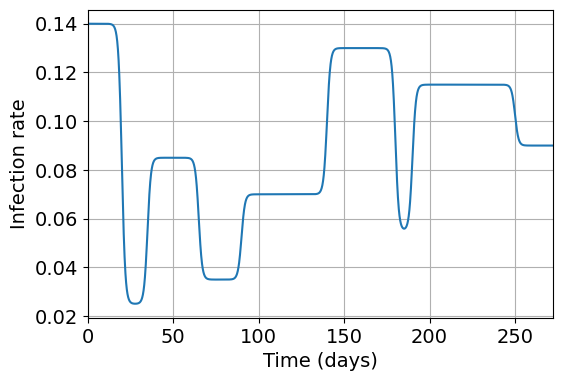

In [14]:

### CHANGE HERE #######

rng = np.random.default_rng(seed=12)

# Toronto
p = 0.005 # probability of success


#### With mobility tensor   

for kk in range(1,len(tmoh)):

    for gg in range(0,N_city):

        L_sum = 0
        for ll in range(0,N_city):

            Nlm = 0
            L_cityinf = 0
            
            for mm in range(0,N_city):
                Nlm =  Nlm + M[0,mm,ll,kk-1] * S[kk-1,mm] +  M[1,mm,ll,kk-1] * E[kk-1,mm] + M[2,mm,ll,kk-1] * I[kk-1,mm] + M[3,mm,ll,kk-1] * R[kk-1,mm]

                L_cityinf = L_cityinf + (beta_e[kk-1,ll] * M[1,mm,ll,kk-1] * E[kk-1,mm] + beta_i[kk-1,ll] * M[2,mm,ll,kk-1] * I[kk-1,mm])


            L_sum = L_sum + (M[0,gg,ll,kk-1] * L_cityinf)/Nlm


        L_Force[kk-1,gg] = L_sum


        S[kk,gg] = S[kk-1,gg] - dt*(L_Force[kk-1,gg]*S[kk-1,gg])
        E[kk,gg] = E[kk-1,gg] + dt*(L_Force[kk-1,gg]*S[kk-1,gg] - (gamma_i + gamma_e)*E[kk-1,gg])
        I[kk,gg] = I[kk-1,gg] + dt*(gamma_i*E[kk-1,gg] - (gamma_r + gamma_d)*I[kk-1,gg])
        R[kk,gg] = R[kk-1,gg] + dt*(gamma_e*E[kk-1,gg] + gamma_r*I[kk-1,gg])
        D[kk,gg] = D[kk-1,gg] + dt*(gamma_d*I[kk-1,gg])
        N[kk,gg] = S[kk,gg] +  E[kk,gg] + I[kk,gg] + R[kk,gg]


        ## For collecting the model output only at data points
        if( kk%ndiv == 0 ):
            idxmoh = int(kk/ndiv)
            r = (p*I[kk,gg])/(1-p) #number of successes
            I_synthetic[idxmoh,gg] = rng.negative_binomial(r,p)

        

#### CHANGE HERE
### Save the synthetic data in CSV file for future use
np.savetxt('./coupled_TD_synthetic_data.csv', I_synthetic, delimiter=",")

### Save true model output
np.savetxt('./coupled_TD_synthetic_true.csv', I, delimiter=",")
np.savetxt('./coupled_TD_synthetic_true_beta.csv', beta_i, delimiter=",")

for kk in range(N_city):
    fig1, ax1 = plt.subplots(figsize=(6, 4))
    plt.plot(t, I_synthetic[:,kk], '*', markersize=6, label=f'Synthetic data-{kk}')
    plt.plot(tmoh, I[:,kk], '-',linewidth=2, label=f'Model output-{kk}')
    # plt.plot(tmoh, I[:,1], '-',linewidth=2, label='Model output-1')
    plt.legend(loc='best')
    plt.xlabel('Time (days)')
    plt.xlim([0,tlim])
    plt.ylabel('Population')
    plt.grid()
    # plt.savefig('./figs/synthetic_data.pdf')
    plt.show()




for kk in range(N_city):
    fig2, ax2 = plt.subplots(figsize=(6, 4))
    ax2.set_xlim([0,tlim])
    ax2.set_xlabel('Time (days)')
    ax2.set_ylabel('Infection rate') 
    ax2.grid()
    plt.plot(tmoh, beta_i[:,kk], label=f'Synthetic model of infection rate-{kk}')
    # plt.plot(tmoh, beta_i[:,1], label='Synthetic model of infection rate-2')
    ax1.legend(loc='best')
    # plt.savefig('./figs/beta_true.pdf',  bbox_inches='tight')
    plt.show()


